In [9]:
from ete3 import Tree
import numpy as np
import pandas as pd
import os
import sys
import time
# %load_ext snakeviz
path_dir = os.path.dirname(os.getcwd())

In [10]:
# For now, we study of small trees (50 to 199 tips) in the BD model 
path_to_full_params = path_dir+"/Data/BD_simu/small_params1.csv"
path_to_stats = path_dir+"/Data/BD_simu/small_stats.csv"
path_to_trees = path_dir+"/ata/BD_simu/small_simu_trees1.txt"
path_to_vectors = path_dir+"Data/BD_simu/small_CBLV_data1.npy"
path_to_clear_params = path_dir+"/Data/BD_simu/small_params_clear1.csv"
path_to_factors = path_dir+"/Data/BD_simu/small_factors1.csv"

MAX_SIZE_SMALL = 201
MAX_SIZE_LARGE = 501

# Create design (parameters) data

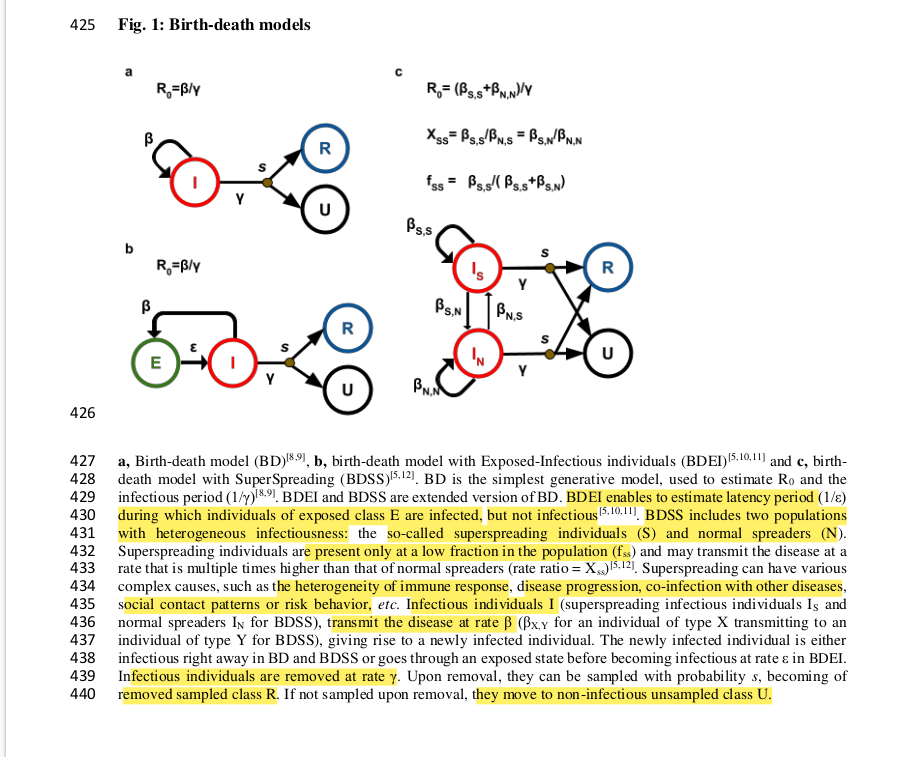


tree size between 50 and 199 (for small tree) or 200 and 500 (for large tree)

In [5]:
nb_simu = 40000 #4,000,000 in the paper

# nombre moyen attendu de cas directement générés par un cas dans une population où tous les individus sont sensibles à l'infection
R_nought = 4*np.random.rand(nb_simu)+1
gamma = 0.9*np.random.rand(nb_simu)+0.1 

params = {
    'R_nought': R_nought,
    'transmission_rate':R_nought*gamma, # beta = R_0*gamma
    'removal_rate': gamma,
    'sampling_proba': 0.99*np.random.rand(nb_simu)+0.01,
    'infectious_time': 1/gamma,
    'tree_size': 149*np.random.rand(nb_simu)+50 # between 50 and 199 (for small trees)
}

df = pd.DataFrame(params)
df.to_csv(path_to_full_params, index=False)
df

,R_nought,transmission_rate,removal_rate,sampling_proba,infectious_time,tree_size
0,3.480877,0.564814,0.162262,0.223154,6.162871,176.612612
1,3.796169,2.032745,0.535473,0.327842,1.867509,104.951736
2,1.895748,1.730196,0.912672,0.175347,1.095684,97.822205
3,1.672328,0.337621,0.201887,0.132491,4.953272,156.591197
4,2.198302,1.186988,0.539957,0.070163,1.852001,99.338326
...,...,...,...,...,...,...
39995,4.582976,3.222615,0.703171,0.861065,1.422130,193.684599
39996,1.210039,1.001471,0.827635,0.481261,1.208261,142.745663
39997,1.155166,0.561995,0.486505,0.115593,2.055476,99.366138
39998,2.408597,0.506490,0.210284,0.282886,4.755466,173.539699


# Simulate trees 

In [6]:
# initiate attributes of nodes
# reasons why a branch stops (transmission, removed/sampled/unsampled tips before the end of simulations)
STOP_REASON = 'stop_reason' #....
STOP_UNKNOWN = 0  #
STOP_TRANSMISSION = 1 #
STOP_REMOVAL_WOS = 2 #
STOP_SAMPLING = 3  #
STOP_TIME = 4  #

#feature to be add to the nodes of the trees
HISTORY = 'history'  
SAMPLING = 'sampling'
TRANSMISSION = 'transmission'
DIST_TO_START = 'DIST_TO_START'
PROCESSED = 'processed'

In a notebook, the %timeit magic function is the best to use because it runs the function many times in a loop to get a more accurate estimate of the execution time of short functions.

In [63]:
# SIMULATE the trees
# import time

sys.setrecursionlimit(100000)
def main():
    
    design = pd.read_csv(path_to_full_params)
    nb_samples = len(design)
    
    # PREPARE EXPORT
    col = ['tree']
    forest_export = pd.DataFrame(index=design.index, columns=col)

#     col2 = ['total_leaves', 'removed_leaves', 'sampled_leaves', 'time_of_simulation', 'nb_trials']
#     stats_export = pd.DataFrame(index=design.index, columns=col2)

    # start = time.time()
    for experiment_id in range(nb_samples):

        params = design.iloc[experiment_id, ]

        # simulation
        tr = simulate_bd_tree_gillespie(transmission_r=params[1], removal_r=params[2], sampling_p=params[3],
                                                        max_s=params[5], max_t=maxTime)

        # STOCK the tree
        # remove unsampled tips
        tr = remove_certain_leaves(tr, to_remove=lambda node: getattr(node, STOP_REASON) != STOP_SAMPLING)
        if tr is not None:
            forest_export.iloc[experiment_id][0] = tr.write(
                features=['DIST_TO_START', 'stop_reason'], format_root_node=True,
                format=3)
        else:
            forest_export.iloc[experiment_id][0] = "NA"
            
    forest_export.to_csv(path_or_buf=path_to_trees, index=False, header=True)

#         stats_export.iloc[experiment_id] = vector_counter
    #     if experiment_id % 100 ==0:
    #         print(f"{experiment_id+1} trees have been simulated")
    #         print(f"It takes {time.time()-start} s")

In [12]:
# Profiling the simulation part
%snakeviz main()

# profiler = cProfile.Profile()
# profiler.enable()
# main()
# profiler.disable()
# stats = pstats.Stats(profiler).sort_stats('tottime')
# stats.strip_dirs()
# stats.print_stats()
# # Export profiler output to file
# stats.dump_stats('export-profile')

 
*** Profile stats marshalled to file '/tmp/tmp44nyww8t'. 
Embedding SnakeViz in this document...


In [8]:
#SIMULATE TREES using multiprocessing (parallelization)
from multiprocessing import Pool


maxTime = 9999
design = pd.read_csv(path_to_full_params)
nb_samples = len(design)

seq = [list(design.iloc[i]) for i in range(nb_samples)] # we have to use sequence to use Pool.map

def simu_main(params):
    tr = simulate_bd_tree_gillespie(transmission_r=params[1], removal_r=params[2], sampling_p=params[3],
                                                        max_s=params[5], max_t=maxTime)
    tr = remove_certain_leaves(tr, to_remove=lambda node: getattr(node, STOP_REASON) != STOP_SAMPLING)
    if tr is not None:
        return tr.write(
            features=['DIST_TO_START', 'stop_reason'], format_root_node=True,
            format=3)
    else:
        return "NA"
    
    
start = time.time()
with Pool(4) as p:
    res = p.map(simu_main, seq)
    
forest = pd.DataFrame(res, columns=['Tree'])

print("It takes : ", time.time()-start, 's')

It takes :  46402.297498464584


In [9]:
forest.to_csv(path_or_buf=path_to_trees, index=False, header=True)

In [10]:
46402.297498464584/3600

12.88952708290683

# Complete and Compact tree representation


In [4]:
# TREE RESCALING
def rescale_tree(tree, target_avg_length=1):
    """
    Returns the rescaling factor and rescale the tree
    :params str_tree: string, newick tree on which we compute the rescaling factor is computed
    :params target_avg_length: float, the average branch length to which we want to rescale the tree
    :returns: float, resc_factor
    """    
    
    branch_lengths = [node.dist for node in tree.traverse()]
    resc_factor = np.mean(branch_lengths)/target_avg_length
    
    for node in tree.traverse():
        node.dist /= resc_factor
    
    return resc_factor


#Check tree rescaling works

## My own version of CBLV encoding

In [5]:
def ladderize(tre):
    """
    Tree ladderization: the branch supporting the most recently sampled subtree is rotated to the left
    :params tre: ete3 Tree, binary tree we want to ladderize
    :return: void, modified the tree tre
    """
    
    # feature to know which subtree is the most recent
    for node in tre.iter_descendants("postorder"):
        if node.is_leaf():
            node.add_feature('subtree_size', node.dist)
        else:
            children = node.children
            node.add_feature('subtree_size', node.dist + max(children[0].subtree_size, children[1].subtree_size))
            
    # swap children so that the most recent is on the left
    for node in tre.traverse():

        children = node.children #is node is leaf children==None
        if children:
            if children[0].subtree_size < children[1].subtree_size:
                node.swap_children()
                
    
#             children[0].del_feature("subtree_size")
#             children[1].del_feature("subtree_size")
                
        
def inorder_traverse(node, previous_node, root, vect_lf=[], vect_in=[]):
    """
    Tree traversal (standart recursive algorithm from the depth first family) and encoding
    Inorder tree walk (binary search tree)
    :param node: 
    :param previous_node:
    :param root:
    :param vect_lf:
    :param vect_in:
    :return: 
    """

    if node.is_root():
        node.add_feature('dist_to_root', 0)
        previous_depth = 0
    else:
        previous_depth = node.up.dist_to_root

    
    if not node.is_leaf(): # node has always 2 children, provided that it is not a leaf
        node.add_feature('dist_to_root', node.dist + previous_depth)
        
        inorder_traverse(node.children[0], previous_node, root, vect_lf=vect_lf, vect_in=vect_in)
        
        #for internal node, we add its distance to the root
        vect_in.append(node.dist_to_root)
        
        previous_node = node
        inorder_traverse(node.children[1], previous_node, root, vect_lf=vect_lf, vect_in=vect_in)
        
    else:
        #for tips, we add its distance to the previously visited node
        vect_lf.append(node.dist+previous_depth - previous_node.dist_to_root)

            
    return vect_lf, vect_in

    
    
def to_CBLV(tre, maxSize, sampling_p):
    """
    :param tree: ete3 tree, tree that we want to vectorize
    :param maxSize:
    :return:
    """

    # Tree ladderization
    ladderize(tre)
    #print(tre.get_ascii("name"))
    # Get 
    # Encoding
    vect_lf, vect_in = inorder_traverse(tre, tre, tre, vect_lf=[], vect_in=[])
    
    # Zero-completion
    tree_vect = np.zeros((2, maxSize))
    tree_vect[0, :len(vect_lf)] = vect_lf
    tree_vect[1, :len(vect_in)] = vect_in
    
    tree_vect[:, -1] = [sampling_p]*2
    
    return tree_vect
 
    
#ladderize(test_tree)
#inorder_traverse(test_tree, test_tree, test_tree)
#to_CBLV(test_tree, 10)

In [6]:
# a simple example to check if the vectorization works well
# test_tree = Tree("(a:3, ((b:2, c)C:2, (d,e:4)D)B)A;", format=1)
# print(test_tree.get_ascii("names"))

In [22]:
# to_CBLV(test_tree, 10, .25)

array([[6.  , 1.  , 4.  , 1.  , 3.  , 0.  , 0.  , 0.  , 0.  , 0.25],
       [2.  , 1.  , 3.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]])

## Store an example

I export an example to test it with the phylodeep library

In [37]:
# sample = 0

# start = time.time()

# test_root, test_vect_c = simulate_bd_tree_gillespie(
#                                                 transmission_r=design.loc[sample][1], 
#                                                 removal_r=design.loc[sample][2], 
#                                                 sampling_p=design.loc[sample][3],
#                                                 max_s=design.loc[sample][5], max_t=maxTime
#                                             )
# # STOCK the tree
# # remove unsampled tips
# test_root = remove_certain_leaves(test_root, to_remove=lambda node: getattr(node, STOP_REASON) != STOP_SAMPLING)
# if test_root is not None:
#     with open("Data/test_tree.txt", 'w') as ft: # save the tree
#         written_tree = test_root.write(
#                                 features=['DIST_TO_START', 'stop_reason'], format_root_node=True,
#                                 format=3)
#         ft.write(written_tree)
#     # store the params of test design.loc[sample] wich a pandas.Series as txt file cause it takes less place in memory (194 octets)
#     design.loc[sample].to_csv("Data/test_params.txt")
        
# else:
#     written_tree = None
#     print("Choose another sample !")
    
# print("The simulation of this tree takes a time of: ", time.time()-start, 's')

# print stats
# print("For the test simu tree: \n ['total_branches', 'total_removed', 'number_infectious_leaves', 'number_sampled'] \n",
#       test_vect_c)

In [64]:
# if written_tree:
#     test_tree = Tree(written_tree, format=3)
    
#     fact = rescale_tree(test_tree) #tree is rescaled
#     params_to_scale = ['transmission_rate', 'removal_rate', "infectious_time"]
#     params_for_rescale_tree = design.loc[sample]
#     params_for_rescale_tree[params_to_scale] /= fact # time dependent parameters are rescaled
            
#     # store CBLV representation
#     test_CBLV = to_CBLV(test_tree, MAX_SIZE_SMALL, design.loc[sample]['sampling_proba'])
    
#     # save
#     written_rescale_tree = test_tree.write(
#                                 features=['DIST_TO_START', 'stop_reason'], format_root_node=True,
#                                 format=3)
#     with open("Data/test_rescale_tree.txt", 'w') as f:
#         f.write(written_rescale_tree)
#     params_for_rescale_tree["rescale_factor"] = fact
#     params_for_rescale_tree.to_csv("Data/test_rescale_params.txt")
        
# else : 
#     print("Choose another sample in the previous cell !")

# Generate data 

In [7]:
def transform_raw_data(param_file, trees_file, vectors_file, new_params_file, factors_file, maxSize=MAX_SIZE_SMALL):
    """
    Remove label that leads to no tree 
    Rescale time dependent parameters in design
    Rescale tree in forest and turn each tree into his CBLV REPRESENTATION
    """
    
    #Load files
    design = pd.read_csv(param_file)
    forest = pd.read_csv(trees_file)
    
    params_to_scale = ['transmission_rate', 'removal_rate', "infectious_time"] #bêta, gamma et 1/gamma dependent du temps
    data_vect = []
    resc_fact_data = []
    sim_range = forest.index
    for i in sim_range:
        
        #Remove chimera
        if isinstance(forest.loc[i][0], float): # is forest.loc[i] is NAN
            design.drop(i, inplace=True)
            forest.drop(i, inplace=True)
        else:
            tree = Tree(forest.loc[i][0], format=3)
            resc_fact = rescale_tree(tree) #tree is rescaled
            resc_fact_data.append(resc_fact) 
            
            design.loc[i][params_to_scale] /= resc_fact #some corresponding parameters are rescaled

            # stock CBLV representation
            data_vect.append(to_CBLV(tree, maxSize, design.loc[i]['sampling_proba']))
            
    # save features and labels        
    np.save(vectors_file, np.array(data_vect))
    design.to_csv(new_params_file, index=True)
    # save rescale factors
    resc_fact_data = pd.DataFrame(resc_fact_data, columns=["rescale factor"])
    resc_fact_data.to_csv(factors_file, index=False)
    

In [8]:
start = time.time()

def trans_main():
    transform_raw_data(path_to_full_params, 
                       path_to_trees, 
                       path_to_vectors, 
                       path_to_clear_params, 
                       path_to_factors
                      )
    
# %snakeviz trans_main()
trans_main()
print(f"It takes {time.time()-start} s")

FileNotFoundError: [Errno 2] No such file or directory: '/home/ivati/montages_reseau/backup/Data/BD_simu/small_params1.csv'

In [36]:
res = pd.read_csv(path_to_factors)
print(f"After conversion, it stays {res.size} input data !")

After conversion, it stays 33311 input data


# Test sur les données de Zurich

In [39]:
Zurich_tree = Tree("Zurich_test/HIV_tree.trees")
print(Zurich_tree.get_ascii(attributes=["dist"]))
Zurich_tree_size = len(Zurich_tree.get_leaves())
print(Zurich_tree_size)


                                                           /-10.16416808
                                               /0.5890302188
                                              |            \-15.40416808
                                    /4.832574108
                                   |          |           /-6.40440765
                                   |           \2.808790652
                         /4.020358407                    |           /-4.572777979
                        |          |                      \1.941629671
                        |          |                                 \-5.572777979
                        |          |
                        |           \-14.34577241
                        |
                        |                                           /-3.224962271
                        |                                /12.37148262
                        |                     /3.118289676          \-0.8149622708
                        |  

In [40]:
# approximated sampling probability (see article)
samp_p = 0.25

#rescale
Zurich_resc_factor = rescale_tree(Zurich_tree)
print(Zurich_tree.get_ascii(attributes=["dist"]))
#convert to CBLV representation
Zurich_vector = to_CBLV(Zurich_tree, MAX_SIZE_SMALL, 0.25)
# Store Zurich tree 's CBLV representation
np.save("Zurich_test/CBLV_vector.npy", Zurich_vector)

# store rescale factor
with open("Zurich_test/resc_factor.txt", "w") as f:
    f.write("The Zurich tree's rescale factor is:"+str(Zurich_resc_factor))


                                                                                               /-1.9644288049936711
                                                                            /0.11384187271551344
                                                                           |                   \-2.9771636257038416
                                                          /0.9339916169530519
                                                         |                 |                  /-1.237779891827785
                                                         |                  \0.5428549804132867
                                        /0.7770146852106433                                  |                  /-0.8837808180744237
                                       |                 |                                    \0.3752587741881168
                                       |                 |                                                      \-1.0770508220267463
  

In [41]:
Zurich_resc_factor

5.174108653956917